# Get the Data

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

In [22]:
import tensorflow as tf
#from tensorflow import keras
import keras
print(tf.__version__)
print(keras.__version__)

2.16.1
3.0.5


## Define global constants

In [23]:
#MY_OPTIMIZER = "SGD"
# MY_EPOCHS = 1000
# MY_LEARNING_RATE = 0.000001
# MY_BATCH_SIZE = 2048
MY_EPOCHS = 1000
MY_LEARNING_RATE = 0.000001
MY_BATCH_SIZE = 128

# Get the Data

In [24]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()
maneuvers.shape

(2051, 8)

In [25]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,2051.000000,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03,2.051000e+03
mean,3144.884951,-9.916647e-01,1.357625e-07,8.983636e-04,2.772001e-08,9.931020e-03,-7.613491e-08,1.678592e-11
std,1811.726067,1.058217e-09,1.202943e-07,5.307901e-09,2.456665e-08,3.606267e-09,6.736846e-08,8.925691e-13
min,9.177680,-9.916647e-01,-8.264015e-11,8.983543e-04,-1.957939e-11,9.931014e-03,-2.261367e-07,1.380825e-11
25%,1577.031315,-9.916647e-01,2.668074e-08,8.983590e-04,5.438768e-09,9.931017e-03,-1.280591e-07,1.618974e-11
50%,3144.884951,-9.916647e-01,1.027174e-07,8.983636e-04,2.097238e-08,9.931020e-03,-5.764007e-08,1.676073e-11
75%,4712.738586,-9.916647e-01,2.282766e-07,8.983682e-04,4.661922e-08,9.931023e-03,-1.495125e-08,1.737429e-11
max,6280.592222,-9.916647e-01,4.033941e-07,8.983727e-04,8.238304e-08,9.931027e-03,-5.776291e-12,2.054861e-11


## Add/Drop Features

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [26]:
# Drop dx and dz features, since they are almost proportional to y
#maneuvers = maneuvers.drop(["dx", "dz"], axis=1)

#maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)


# Prepare the Data for Machine Learning Algorithms

In [27]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers[["dv_st"]].copy()

# Convert dataframe to a numpy array before training, to avoid issues with dataframe headers.
maneuvers_predictors = maneuvers_predictors.to_numpy()
maneuvers_labels = maneuvers_labels.to_numpy()

#maneuvers_predictors.head()
#maneuvers_labels.head()

## Create a Train/Test/Validation Set

In [28]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
maneuvers_predictors, maneuvers_labels, test_size=0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(
X_train_full, y_train_full)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(X_train[:4])

(1230, 6)
(411, 6)
(410, 6)
[[-9.91664719e-01  1.47469339e-07  8.98365318e-04  3.01132075e-08
   9.93102161e-03 -8.27352873e-08]
 [-9.91664720e-01  3.72324137e-07  8.98372000e-04  7.60242345e-08
   9.93102602e-03 -2.08492990e-07]
 [-9.91664718e-01  5.21773785e-08  8.98360912e-04  1.06556627e-08
   9.93101844e-03 -2.94254043e-08]
 [-9.91664719e-01  2.45778240e-07  8.98368727e-04  5.01926119e-08
   9.93102374e-03 -1.37855880e-07]]


In [29]:
# Scale all the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:5]

array([[0.39821666, 0.36570134, 0.59785989, 0.36567755, 0.60553031,
        0.6341521 ],
       [0.04031593, 0.92299443, 0.96204313, 0.92283251, 0.95834889,
        0.07802418],
       [0.64672697, 0.12952424, 0.3577235 , 0.12954979, 0.35151403,
        0.8699    ],
       [0.22192281, 0.60935579, 0.78365068, 0.6093519 , 0.77571014,
        0.39039685],
       [0.44693154, 0.31165182, 0.5602173 , 0.31163707, 0.54990357,
        0.68805182]])

In [30]:
# Scale target variable dv_st as well.
# Rationale: dv_st takes very small values (10^{-8}), 
# so MSE may be tiny and not computed properly. Also, NN may converge faster?

scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)
y_valid_scaled = scaler_target.transform(y_valid)
y_test_scaled = scaler_target.transform(y_test)
y_train_scaled[:5]

array([[0.39826457],
       [0.54160334],
       [0.34155912],
       [0.5423771 ],
       [0.56390416]])

In [31]:
# Try adding degree 2 polynomial features. This worked well for polynomial regression 
# (see supervised.py).
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled = poly_features.fit_transform(X_train_scaled)
X_valid_scaled = poly_features.transform(X_valid_scaled)
X_test_scaled = poly_features.transform(X_test_scaled)

X_train_scaled[:5]

array([[0.39821666, 0.36570134, 0.59785989, 0.36567755, 0.60553031,
        0.6341521 , 0.15857651, 0.14562837, 0.23807777, 0.14561889,
        0.24113226, 0.25252994, 0.13373747, 0.21863816, 0.13372877,
        0.22144324, 0.23191027, 0.35743644, 0.21862394, 0.36202228,
        0.37913411, 0.13372007, 0.22142884, 0.23189519, 0.36666695,
        0.38399832, 0.40214889],
       [0.04031593, 0.92299443, 0.96204313, 0.92283251, 0.95834889,
        0.07802418, 0.00162537, 0.03721138, 0.03878566, 0.03720485,
        0.03863672, 0.00314562, 0.85191873, 0.88796046, 0.85176927,
        0.88455069, 0.07201589, 0.92552699, 0.88780468, 0.92197297,
        0.07506263, 0.85161984, 0.88439551, 0.07200325, 0.91843259,
        0.07477439, 0.00608777],
       [0.64672697, 0.12952424, 0.3577235 , 0.12954979, 0.35151403,
        0.8699    , 0.41825577, 0.08376682, 0.23134944, 0.08378335,
        0.2273336 , 0.56258779, 0.01677653, 0.04633387, 0.01677984,
        0.04552959, 0.11267314, 0.12796611, 0.0463

In [32]:
import joblib
joblib.dump(scaler, 'scaler.gz')
joblib.dump(scaler_target, 'scaler_target.gz')

['scaler_target.gz']

In [33]:
cov=np.cov(X_train_scaled, rowvar=False)
cond = np.linalg.cond(cov)
max_eig = np.linalg.eigvals(cov).max()
print(f"condition number is {cond}, max eigenvalue {max_eig:.2f}")

condition number is 5.575073037645295e+17, max eigenvalue 1.52+0.00j


# Building, Training, and Evaluating the Model

The output layer has a single neuron (since we only want to
predict a single value) and uses no activation function, and the loss function is the mean squared error. 

Since the dataset is quite noisy, we just use a single hidden layer with fewer neurons than before, to avoid overfitting.

In [34]:
model = keras.models.Sequential([
keras.layers.Dense(300, activation="relu", input_shape=X_train_scaled.shape[1:]),
keras.layers.Dense(100, activation="relu"),
keras.layers.Dense(1)
])
model.summary()

/home/pablo/anaconda3/envs/halo/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 300)            │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,601 (150.79 KB)

 Trainable params: 38,601 (150.79 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
#opt = keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE)
opt = keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE)
model.compile(loss="mean_squared_error", optimizer=opt)
history = model.fit(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE,
                    validation_data=(X_valid_scaled, y_valid_scaled))

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2313 - val_loss: 0.2252
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2292 - val_loss: 0.2236
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2279 - val_loss: 0.2220
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2265 - val_loss: 0.2204
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2271 - val_loss: 0.2187
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2202 - val_loss: 0.2172
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2224 - val_loss: 0.2156
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2139 - val_loss: 0.2140
Epoch 9/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2202 - val_loss: 0.2125
Epoch 10/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2146 - val_loss: 0.2109
Epoch 11/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2154 - val_loss: 0.2094
Epoch 12/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.1376
Epoch 69/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1423 - val_loss: 0.1366
Epoch 70/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1407 - val_loss: 0.1356
Epoch 71/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.1346
Epoch 72/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1418 - val_loss: 0.1336
Epoch 73/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1378 - val_loss: 0.1326
Epoch 74/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1357 - val_loss: 0.1316
Epoch 75/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1337 - val_loss: 0.1307
Epoch 76/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1357 - val_loss: 0.1297
Epoch 77/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1282 - val_loss: 0.1287
Epoch 78/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1314 - val_loss: 0.1278
Epoch 79/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0875 - val_loss: 0.0836
Epoch 136/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0840 - val_loss: 0.0830
Epoch 137/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0845 - val_loss: 0.0824
Epoch 138/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0835 - val_loss: 0.0818
Epoch 139/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0845 - val_loss: 0.0812
Epoch 140/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0828 - val_loss: 0.0806
Epoch 141/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0811 - val_loss: 0.0800
Epoch 142/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0808 - val_loss: 0.0795
Epoch 143/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0830 - val_loss: 0.0789
Epoch 144/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 - val_loss: 0.0783
Epoch 145/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0799 - val_loss: 0.0777
Epoch 146/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0528 - val_loss: 0.0519
Epoch 203/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0543 - val_loss: 0.0515
Epoch 204/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0517 - val_loss: 0.0512
Epoch 205/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0531 - val_loss: 0.0508
Epoch 206/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 - val_loss: 0.0505
Epoch 207/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534 - val_loss: 0.0501
Epoch 208/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0521 - val_loss: 0.0498
Epoch 209/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0501 - val_loss: 0.0495
Epoch 210/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 - val_loss: 0.0492
Epoch 211/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - val_loss: 0.0488
Epoch 212/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - val_loss: 0.0485
Epoch 213/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0348 - val_loss: 0.0344
Epoch 270/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0349 - val_loss: 0.0342
Epoch 271/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.0340
Epoch 272/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342 - val_loss: 0.0338
Epoch 273/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.0336
Epoch 274/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0363 - val_loss: 0.0334
Epoch 275/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.0333
Epoch 276/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - val_loss: 0.0331
Epoch 277/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - val_loss: 0.0329
Epoch 278/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0321 - val_loss: 0.0327
Epoch 279/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - val_loss: 0.0326
Epoch 280/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 337/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0247
Epoch 338/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 339/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: 0.0245
Epoch 340/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0244
Epoch 341/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0243
Epoch 342/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0243
Epoch 343/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0242
Epoch 344/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0241
Epoch 345/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0240
Epoch 346/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244 - val_loss: 0.0239
Epoch 347/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.0200
Epoch 404/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.0199
Epoch 405/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0199
Epoch 406/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0198
Epoch 407/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0198
Epoch 408/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.0197
Epoch 409/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - val_loss: 0.0197
Epoch 410/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - val_loss: 0.0196
Epoch 411/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0196
Epoch 412/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 413/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.0195
Epoch 414/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 471/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0179
Epoch 472/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.0179
Epoch 473/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.0178
Epoch 474/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0178
Epoch 475/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - val_loss: 0.0178
Epoch 476/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - val_loss: 0.0178
Epoch 477/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0178
Epoch 478/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0178
Epoch 479/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.0177
Epoch 480/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - val_loss: 0.0177
Epoch 481/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 538/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0173
Epoch 539/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0172
Epoch 540/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 541/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 542/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 543/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 544/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0172
Epoch 545/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.0172
Epoch 546/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 547/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 548/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0171
Epoch 605/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 606/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 607/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 608/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 609/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 610/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 611/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 612/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 613/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 614/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 615/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 672/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - val_loss: 0.0171
Epoch 673/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 674/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 675/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0171
Epoch 676/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0171
Epoch 677/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 678/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 679/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 680/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 681/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0171
Epoch 682/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 739/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.0171
Epoch 740/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 741/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.0171
Epoch 742/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0171
Epoch 743/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 744/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0171
Epoch 745/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0171
Epoch 746/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 747/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0175 - val_loss: 0.0171
Epoch 748/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 749/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.0171
Epoch 806/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0171
Epoch 807/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 808/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 809/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0171
Epoch 810/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 811/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0171
Epoch 812/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 813/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.0172
Epoch 814/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 815/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 816/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - val_loss: 0.0172
Epoch 873/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0172
Epoch 874/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 875/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 876/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 877/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 878/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0172
Epoch 879/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 880/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 881/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 882/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 883/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - val_loss: 0.0172
Epoch 940/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0172
Epoch 941/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 942/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - val_loss: 0.0172
Epoch 943/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 944/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0172
Epoch 945/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 946/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 947/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 948/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0172
Epoch 949/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0172
Epoch 950/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

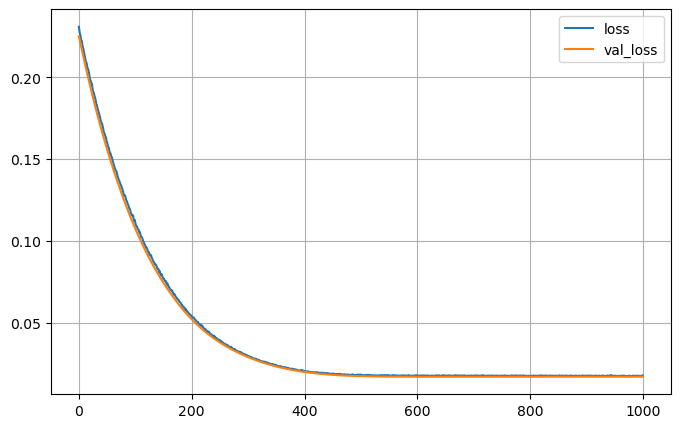

In [36]:
# Plot learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 5e-4) # set the vertical range to [0-1]
plt.show()

In [37]:
mse_test = model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0186


0.13175923977487936

In [38]:
X_new = X_test_scaled[:3] # pretend these are new instances
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [39]:
y_test_scaled[:3]

array([[0.70387156],
       [0.46099428],
       [0.14043717]])

In [40]:
y_pred[:3]

array([[0.44172606],
       [0.43740255],
       [0.45245737]], dtype=float32)

# Fine-Tuning Neural Network Hyperparameters

Wrap our Keras models in objects that mimic regular Scikit-Learn regressors.

def build_model(n_hidden, n_neurons, learning_rate, 
                input_shape):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", 
                                     **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

from scikeras.wrappers import KerasRegressor

keras_reg = KerasRegressor(build_model, n_hidden=1, n_neurons=30, learning_rate=3e-3, 
                input_shape=[8])

In [602]:
import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
               # Tune number of units separately for each layer.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    model.add(layers.Dense(1))
    #learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        #optimizer=keras.optimizers.SGD(learning_rate=MY_LEARNING_RATE),
        optimizer=keras.optimizers.Adam(learning_rate=MY_LEARNING_RATE),
        #optimizer=MY_OPTIMIZER,
        loss="mean_squared_error",
    )
    return model

In [603]:
# Quickly test if model builds successfuly
import keras_tuner

build_model(keras_tuner.HyperParameters())

<Sequential name=sequential_2, built=False>

Use a randomized search to train hundreds of hyperparameter combinations  and see which one performs best on the validation set.

Note that RandomizedSearchCV uses K-fold cross-validation, so it
does not use X_valid and y_valid_scaled . These are just used for early stopping.

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, 
                                   n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_scaled, epochs=100,
                  validation_data=(X_valid, y_valid_scaled),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [604]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [605]:
# print a summary of the search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}


Then, start the search for the best hyperparameter configuration. All the arguments passed to search is passed to model.fit() in each execution. Remember to pass validation_data to evaluate the model.

In [606]:
tuner.search(X_train_scaled, y_train_scaled, epochs=MY_EPOCHS, batch_size=MY_BATCH_SIZE, validation_data=(X_valid_scaled, y_valid_scaled))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
512               |512               |units_0

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0527 - val_loss: 0.0625
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0526 - val_loss: 0.0618
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0513 - val_loss: 0.0612
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0508 - val_loss: 0.0606
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0509 - val_loss: 0.0600
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0506 - val_loss: 0.0594
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0495 - val_loss: 0.0588
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0484 - val_loss: 0.0582
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0486 - val_loss: 0.0576
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - val_loss: 0.0232
Epoch 137/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - val_loss: 0.0231
Epoch 138/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191 - val_loss: 0.0230
Epoch 139/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - val_loss: 0.0230
Epoch 140/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0194 - val_loss: 0.0229
Epoch 141/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - val_loss: 0.0228
Epoch 142/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - val_loss: 0.0227
Epoch 143/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - val_loss: 0.0227
Epoch 144/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - val_loss: 0.0226
Epoch 145/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0190 - val_loss: 0.0225
Epoch 146/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193 - val_loss: 0.0225
Epoch 147/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186 - 

KeyboardInterrupt: 

## Query the results
When search is over, you can retrieve the best model(s). The model is saved at its best performing epoch evaluated on the validation_data.

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
mse_test = best_model.evaluate(X_test_scaled, y_test_scaled)
np.sqrt(mse_test)

In [ ]:
X_new = X_test_scaled[:10] # pretend these are new instances
y_pred = best_model.predict(X_new)

In [ ]:
y_test_scaled[:10]

In [ ]:
y_pred[:10]

In [ ]:
best_model.save("best_model.keras")